# Importation des packages

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [58]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [59]:
data = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Etude du jeu de données

In [60]:
# Your Code
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
None


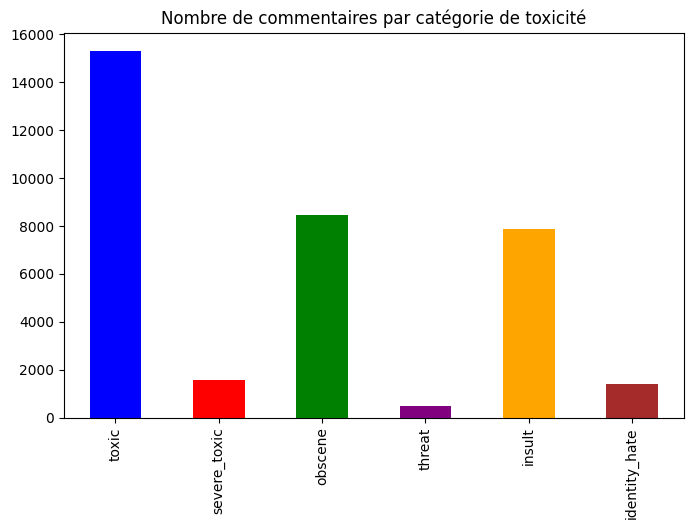

In [61]:
#reparition des classes par catégorie de toxicité

# Compter les occurrences de chaque classe
label_counts = data.iloc[:, 2:].sum()

# Affichage en barres
plt.figure(figsize=(8,5))
label_counts.plot(kind='bar', color=['blue', 'red', 'green', 'purple', 'orange', 'brown'])
plt.title("Nombre de commentaires par catégorie de toxicité")
plt.show()


In [62]:
#voir le pourcentage de commentaires jugés non toxiques

clean_comments = (data.iloc[:, 2:].sum(axis=1) == 0).mean()
print(f"Pourcentage de commentaires non toxiques: {clean_comments:.2%}")


Pourcentage de commentaires non toxiques: 89.83%


In [63]:
#voir des exemples de commentaires (1 toxique et 1 non toxique)

# Exemple d'un commentaire toxique
print(data[data["toxic"] == 1]["comment_text"].sample(5).values)

# Exemple d'un commentaire propre
print(data[(data.iloc[:, 2:].sum(axis=1) == 0)]["comment_text"].sample(5).values)


['Hi! \n\nI wanna rape you!'
 'Terrorize \nI will terrorise you for as long as you live - you are an arrogant, disgusting and rude excuse for a human being & you are going to die soon so I suggest you stop threatening people you bastard.'
 "Being blocked\n\nSo that's your idea of mediation, is it? R Lopez can run amok through Wikipedia with his lying crap, and I get blocked for stating my intention of stopping him unless Wikipedia's rather creaky structures do so. I've seen some silly things since I have been editing here but that would be the silliest."
 'Editing Wikipedia \n\nFuck You, you anal rapist'
 "So the fact that the US Govt wants to put some dude in jail for 6 yrs is irrelevant to you?  The fact that the US Govt wants some dude to PAY restitution in over $160,000 to celebrites is irrelevant to you?  You act like that kind of stuff happens every day.  But I challenge you to name one other person that is has happened to, on the scale that this has happened, anywhere in the cou

In [64]:
#vérifier qu'aucune donnée n'est manquante

print(data.isnull().sum())


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


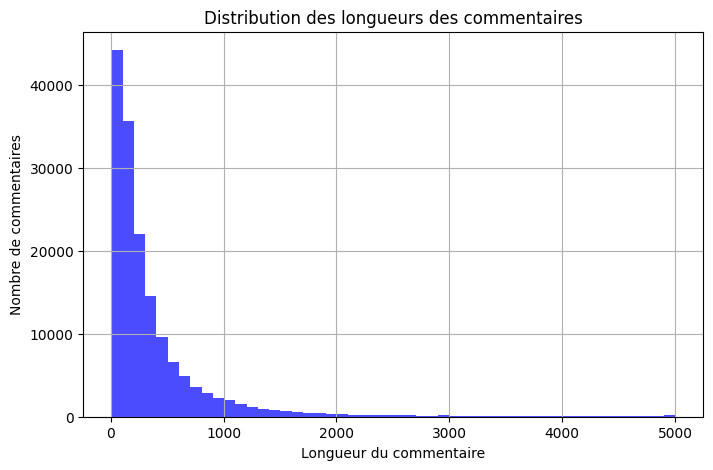

In [65]:
#analyse des longueurs de commentaires

data["comment_length"] = data["comment_text"].apply(len)

plt.figure(figsize=(8,5))
data["comment_length"].hist(bins=50, color='blue', alpha=0.7)
plt.title("Distribution des longueurs des commentaires")
plt.xlabel("Longueur du commentaire")
plt.ylabel("Nombre de commentaires")
plt.show()


In [66]:
pip install wordcloud

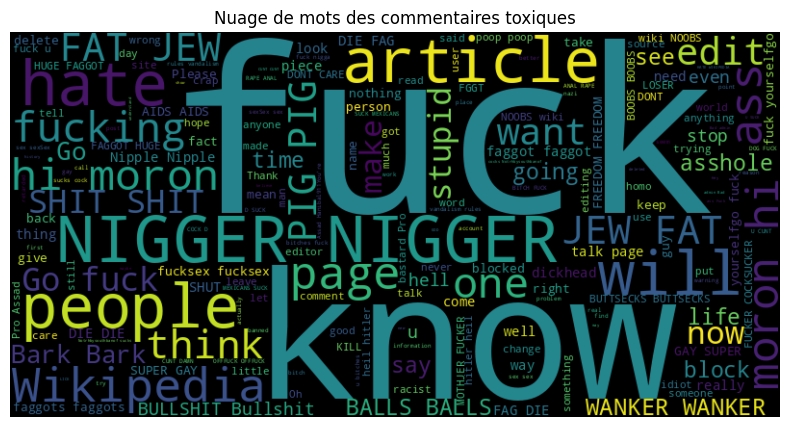

In [67]:
#faire un nuage de mot pour voir les mots toxiques récurrents

from wordcloud import WordCloud

toxic_comments = " ".join(data[data["toxic"] == 1]["comment_text"])
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(toxic_comments)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots des commentaires toxiques")
plt.show()


# Préparation des données

In [68]:
#nettoyage du texte

import nltk
nltk.download('punkt')
nltk.download('punkt_tab') # Download the punkt_tab data

import re
import string
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

STOPWORDS = set(stopwords.words("english"))

def clean_text(text):
    # Mettre en minuscules
    text = text.lower()
    # Supprimer les liens
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Supprimer les mentions et hashtags
    text = re.sub(r'\@\w+|\#','', text)
    # Supprimer la ponctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Supprimer les chiffres
    text = re.sub(r'\d+', '', text)
    # Tokenization
    words = word_tokenize(text)
    # Supprimer les stopwords
    words = [word for word in words if word not in STOPWORDS]
    return " ".join(words)

# Appliquer le nettoyage
data["clean_text"] = data["comment_text"].apply(clean_text)

# Vérifier le résultat
print(data[["comment_text", "clean_text"]].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


                                        comment_text  \
0  Explanation\nWhy the edits made under my usern...   
1  D'aww! He matches this background colour I'm s...   
2  Hey man, I'm really not trying to edit war. It...   
3  "\nMore\nI can't make any real suggestions on ...   
4  You, sir, are my hero. Any chance you remember...   

                                          clean_text  
0  explanation edits made username hardcore metal...  
1  daww matches background colour im seemingly st...  
2  hey man im really trying edit war guy constant...  
3  cant make real suggestions improvement wondere...  
4                sir hero chance remember page thats  


In [69]:
#stemming

from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download("wordnet")

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatisation
    return " ".join(words)

# Appliquer la transformation
data["processed_text"] = data["clean_text"].apply(preprocess_text)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [70]:
#word embeddings pour representer le texte

from gensim.models import Word2Vec

tokenized_sentences = [word_tokenize(text) for text in data["processed_text"]]
word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=2, workers=4)

# Exemple de représentation pour "toxic"
print(word2vec_model.wv["toxic"])

[-0.30541146  0.00351742  0.23935504 -0.01848936 -0.44780275 -0.12989055
  0.01774483  0.50256723 -0.12976514  0.01624471 -0.11268136 -0.26677984
  0.04135383  0.40878823 -0.3047135  -0.45747423 -0.10235073 -0.15737714
  0.14472742 -0.25160173  0.42839468  0.02713407 -0.2892952  -0.5719759
 -0.02331648  0.23763873 -0.07105532 -0.3864262  -0.3286825  -0.01483167
  0.09508356  0.28757817  0.12035077 -0.33793896 -0.03424073  0.1505425
  0.02391958 -0.2430449   0.05893252 -0.35214797  0.28310034 -0.57222754
  0.01703934 -0.05394102  0.30672726 -0.05784001  0.06243764 -0.32930267
  0.08722343 -0.07012691 -0.09737284 -0.30023265  0.05500901 -0.31521842
 -0.07588003  0.04265335 -0.25778544  0.01944959 -0.34477746 -0.06815442
  0.20233738  0.5618817   0.2456153   0.14527586 -0.35896435  0.22945265
  0.17785196  0.09923487 -0.0870771  -0.0370275  -0.02666504  0.37975097
  0.54961836 -0.16264519  0.37666285  0.49861506 -0.07123018 -0.37450048
  0.20733768  0.19160794  0.2219562   0.06882636 -0.6

In [71]:
#gestion des desequilibre des classes

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Get unique classes from the target variable
unique_classes = np.unique(data[labels].values) # Get unique classes from all target columns

# Calculer les poids des classes
class_weights = compute_class_weight(class_weight="balanced", classes=unique_classes, y=data[labels].values.ravel())
print(class_weights)

[ 0.51902685 13.63932418]


# Entraînement du modèle baseline

Nous allons utiliser 2 techniques, la première sera du random forest et pour la deuxième nous utiliserons BERT de Google

In [72]:
# Random Forest

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Prendre un échantillon aléatoire de 10% des données
sample_df = data.sample(frac=0.1, random_state=42)

# Vectorisation TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(sample_df["processed_text"])

# Labels
y = sample_df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement du modèle Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Prédictions
y_pred = rf_model.predict(X_test)

# Évaluation
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.57      0.68       305
           1       0.00      0.00      0.00        27
           2       0.87      0.68      0.76       163
           3       0.00      0.00      0.00        10
           4       0.78      0.53      0.63       161
           5       0.60      0.11      0.19        27

   micro avg       0.82      0.54      0.65       693
   macro avg       0.51      0.32      0.38       693
weighted avg       0.78      0.54      0.63       693
 samples avg       0.05      0.05      0.05       693



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

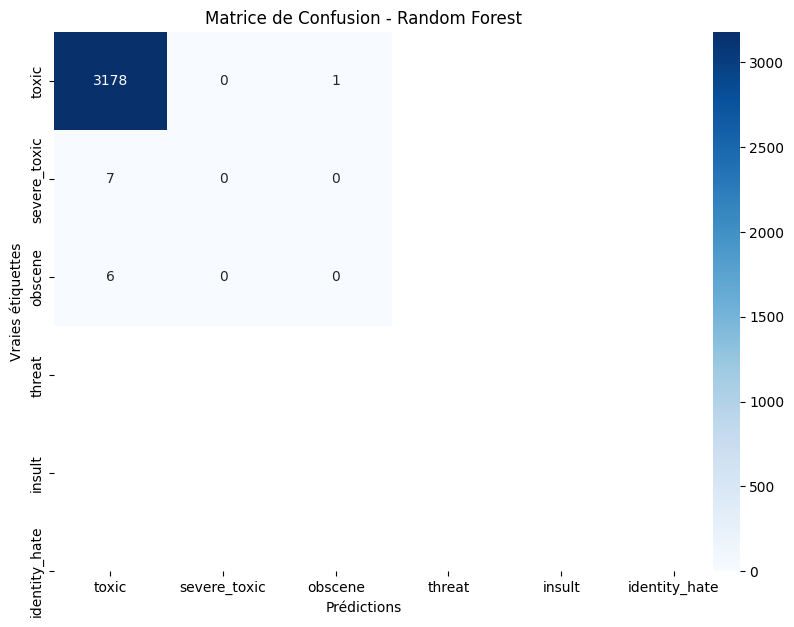

In [73]:
# Matrice de confusion pour le random forest

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Prédictions sur les données de test
y_pred_rf = rf_model.predict(X_test)

# Générer la matrice de confusion
cm = confusion_matrix(y_test.values.argmax(axis=1), y_pred_rf.argmax(axis=1))

# Visualisation de la matrice de confusion
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.columns, yticklabels=y.columns)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de Confusion - Random Forest')
plt.show()

In [74]:
!pip install datasets

In [75]:
# BERT de Google

import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Prendre 10% des données
sample_df = data.sample(frac=0.1, random_state=42)

# Charger le tokenizer
tokenizer = BertTokenizer.from_pretrained("distilbert-base-uncased")

# Fonction de tokenization
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Séparation en train/test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    sample_df["comment_text"].tolist(), sample_df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values, test_size=0.2
)

# Conversion en Dataset Hugging Face
train_dataset = Dataset.from_dict({"text": train_texts, "labels": train_labels.tolist()})
test_dataset = Dataset.from_dict({"text": test_texts, "labels": test_labels.tolist()})

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Charger le modèle BERT
model = BertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=6)


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


Map:   0%|          | 0/12765 [00:00<?, ? examples/s]

Map:   0%|          | 0/3192 [00:00<?, ? examples/s]

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'enc

In [88]:
# Arguments d'entraînement
training_args = TrainingArguments(
    output_dir="./results",  # Répertoire pour sauvegarder les résultats
    evaluation_strategy="epoch",  # Evaluation après chaque époque
    per_device_train_batch_size=4,  # Taille du batch d'entraînement
    per_device_eval_batch_size=4,  # Taille du batch d'évaluation
    num_train_epochs=1,  # Nombre d'époques (1 pour tester rapidement)
    weight_decay=0.01,  # Poids de régularisation
    logging_dir="./logs",  # Répertoire pour les logs
    logging_steps=100,  # Enregistrer les logs toutes les 100 étapes
    save_steps=500,  # Sauvegarder le modèle toutes les 500 étapes
)

# Initialisation du Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,  # Passer le tokenizer au Trainer pour la préparation automatique des données
)

# Entraîner le modèle
trainer.train()


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-88-d1db9c4ba50d>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.000000,7.865315


TrainOutput(global_step=625, training_loss=1.3453485233185348e-06, metrics={'train_runtime': 1079.509, 'train_samples_per_second': 2.316, 'train_steps_per_second': 0.579, 'total_flos': 657777638400000.0, 'train_loss': 1.3453485233185348e-06, 'epoch': 1.0})

In [87]:
# Evaluation

predictions = trainer.predict(test_dataset)
preds = torch.sigmoid(torch.tensor(predictions.predictions))  # Activation sigmoïde
preds = (preds.numpy() > 0.5).astype(int)  # Seuil 0.5 pour classifier

print(classification_report(test_labels, preds))

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import torch
import numpy as np

# Prédictions sur les données de test avec BERT
predictions = trainer.predict(test_dataset)
preds = torch.sigmoid(torch.tensor(predictions.predictions))  # Activation sigmoïde
preds = (preds.numpy() > 0.5).astype(int)

# Calculer la matrice de confusion pour chaque étiquette
cms = multilabel_confusion_matrix(test_labels, preds) # Use multilabel_confusion_matrix instead

# Afficher les matrices de confusion
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, (label, cm) in enumerate(zip(labels, cms)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Matrice de Confusion - {label}')
    axes[i].set_xlabel('Prédictions')
    axes[i].set_ylabel('Vraies étiquettes')
plt.tight_layout()
plt.show()

# Calculer et afficher le rapport de classification pour chaque étiquette
report = classification_report(test_labels, preds, target_names=labels, output_dict=True) # Add target_names for better readability
for label in labels:
    print(f"Rapport de classification pour {label}:")
    print(f"  Précision: {report[label]['precision']:.2f}")
    print(f"  Rappel: {report[label]['recall']:.2f}")
    print(f"  F1-score: {report[label]['f1-score']:.2f}")
    print(f"  Support: {report[label]['support']}")
    print("-" * 30)

# Itération de la modélisation

In [ ]:
# Your Code